In [1]:
# second attempt

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import needed stats libraries too:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
df = pd.read_csv("rural_appraisal_updated.csv", low_memory=False)

In [4]:
# More revised sanity controls before analysis
# Columns to check for out-of-range dates
columns_to_check = ['TAXYR', 'LNDAPRDATE', 'YRBLT', 'EFFYRBLT', 'SALEDATE', 'SALEYEAR', 'UPDATED', 'V_SALEDATE', 'V_SALEYEAR']

# Function to nullify out-of-range dates
def nullify_out_of_range_dates(column):
    try:
        # Convert the column to datetime
        dates = pd.to_datetime(df[column], errors='coerce', format='%m-%d-%y')
        
        # Special adjustments for YRBLT and EFFYRBLT
        if column in ['YRBLT', 'EFFYRBLT']:
            df.loc[df[column] == 0, column] = None
        else:
            # Nullify dates before 1922 or after 2023
            df.loc[(dates.dt.year < 1922) | (dates.dt.year > 2023), column] = None
            if column == 'LNDAPRDATE':
                df.loc[df[column].str.strip().eq(''), column] = None
    except:
        # For non-datetime columns (e.g., TAXYR, SALEYEAR)
        df.loc[(df[column] < 1922) | (df[column] > 2023), column] = None

# Apply the function to the specified columns
for col in columns_to_check:
    nullify_out_of_range_dates(col)

# Check the number of null values in these columns after the operation
null_counts_revised = df[columns_to_check].isnull().sum()

null_counts_revised

TAXYR              0
LNDAPRDATE     16395
YRBLT         145915
EFFYRBLT      147673
SALEDATE           0
SALEYEAR           0
UPDATED            0
V_SALEDATE         0
V_SALEYEAR         0
dtype: int64

In [5]:
# Convert V_SALEYEAR to numeric, coercing errors to NaN
df['V_SALEYEAR'] = pd.to_numeric(df['V_SALEYEAR'], errors='coerce')

# Filter out rows with V_SALEYEAR greater than 2022
df = df[df['V_SALEYEAR'] <= 2022]

In [6]:
# redefine TOPO and ROADTYPE values
# Topography code: 0 Level; 1 Rolling; 2 Mountainous; 3 High; 4 Low; 5 Gully/Waste
# Road type: 0 US Highway; 1 Interchange; 2 State Highway; 3 Paved; 4 Gravel; 5 Dirt; 6 Urban Paved; 7 Curb/Gutter Paved; 8 Private/None

# Replace whitespace with NaN
df['TOPO'].replace(' ', np.nan, inplace=True)
df['ROADTYPE'].replace(' ', np.nan, inplace=True)

# Adjusted mappings
topo_mapping = {
    '0': 'Level',
    '1': 'Rolling',
    '2': 'Mountainous',
    '3': 'High',
    '4': 'Low',
    '5': 'Gully_Waste'
}

roadtype_mapping = {
    '0': 'US_Highway',
    '1': 'Interchange',
    '2': 'State_Highway',
    '3': 'Paved',
    '4': 'Gravel',
    '5': 'Dirt',
    '6': 'Urban_Paved',
    '7': 'Curb_Gutter_Paved',
    '8': 'Private_None'
}

# Apply the mappings
df['TOPO'] = df['TOPO'].map(topo_mapping)
df['ROADTYPE'] = df['ROADTYPE'].map(roadtype_mapping)

# Check unique values in TOPO and ROADTYPE
print(df['TOPO'].unique())
print(df['ROADTYPE'].unique())

['Rolling' nan 'Level' 'Mountainous' 'High' 'Low' 'Gully_Waste']
['Paved' 'Gravel' 'Dirt' 'Private_None' nan 'US_Highway' 'State_Highway'
 'Curb_Gutter_Paved' 'Urban_Paved' 'Interchange']


In [7]:
# create new sub-df
df_sub = df.copy()

df_sub['Acreage_Price'] = df_sub['V_PRICE'] / df_sub['CAMACALCAC']

# Filter out NaN or infinite values
df_sub = df_sub[~df_sub['Acreage_Price'].isnull() & 
                               (df_sub['Acreage_Price'] != float('inf'))]
# tilde is a bitwise negation operator, which can invert a boolean mask

In [8]:
# Creating df_sub2 with whitespace in IMPTYPE and IMP, and IMPVAL = 0
df_sub2 = df_sub[(df_sub['IMPTYPE'].str.strip() == '') & 
                 (df_sub['IMP'].str.strip() == '') & 
                 (df_sub['IMPVAL'] == 0)]

df_sub2.shape

(28509, 76)

In [9]:
# Create a new explicit copy for df_sub2
df_sub2 = df_sub.copy()

# Add the acre^2 column
df_sub2.loc[:, 'acreage_squared'] = df_sub2['CAMACALCAC'] ** 2

# County dummy
county_dummies = pd.get_dummies(df_sub2['COUNTY'], prefix='county', drop_first=True)

# Year dummy
df_sub2['V_SALEYEAR'] = df_sub2['V_SALEYEAR'].astype(int)

year_dummies = pd.get_dummies(df_sub2['V_SALEYEAR'], prefix='year', drop_first=True)

# TOPO dummy
topo_dummies = pd.get_dummies(df_sub2['TOPO'], prefix='topo', drop_first=True)

# ROADTYPE dummy
road_dummies = pd.get_dummies(df_sub2['ROADTYPE'], prefix='road', drop_first=True)

# Merging the dummy variables with df_sub
df_sub2 = pd.concat([df_sub2, county_dummies, year_dummies, topo_dummies, road_dummies], axis=1)

In [10]:
# Replacing spaces with underscores
df_sub2.columns = df_sub2.columns.str.replace(' ', '_')

In [11]:
df_sub2['V_SALEYEAR'].value_counts()

V_SALEYEAR
2021    2176
2022    1884
1996    1624
2020    1623
2006    1599
        ... 
1930       1
1925       1
220        1
1933       1
1910       1
Name: count, Length: 99, dtype: int64

In [12]:
county_columns = [col for col in df_sub2.columns if col.startswith("county_")]
year_columns = [col for col in df_sub2.columns if col.startswith("year_")]
topo_columns = [col for col in df_sub2.columns if col.startswith("topo_")]
road_columns = [col for col in df_sub2.columns if col.startswith("road_")]


# Generate formula components
components = ["CAMACALCAC", "acreage_squared"] + county_columns + year_columns + topo_columns + road_columns

# Construct the regression formula by joining the components with " + "
formula_cleaned = 'Acreage_Price ~ ' + ' + '.join(components)

# Display the cleaned formula
formula_cleaned

'Acreage_Price ~ CAMACALCAC + acreage_squared + county_BEDFORD + county_BENTON + county_BLEDSOE + county_BLOUNT + county_BRADLEY + county_CAMPBELL + county_CANNON + county_CARROLL + county_CARTER + county_CHEATHAM + county_CLAIBORNE + county_CLAY + county_COCKE + county_COFFEE + county_CROCKETT + county_CUMBERLAND + county_DECATUR + county_DEKALB + county_DICKSON + county_DYER + county_FAYETTE + county_FENTRESS + county_FRANKLIN + county_GIBSON + county_GILES + county_GRAINGER + county_GREENE + county_GRUNDY + county_HAMBLEN + county_HANCOCK + county_HARDEMAN + county_HARDIN + county_HAWKINS + county_HAYWOOD + county_HENDERSON + county_HENRY + county_HOUSTON + county_HUMPHREYS + county_JACKSON + county_JEFFERSON + county_JOHNSON + county_LAKE + county_LAUDERDALE + county_LAWRENCE + county_LEWIS + county_LINCOLN + county_LOUDON + county_MACON + county_MADISON + county_MARION + county_MARSHALL + county_MAURY + county_MCMINN + county_MCNAIRY + county_MEIGS + county_MONROE + county_MOORE +

## Acreage_Price = β0 + β1Acre + β2Acre^2 + [(County, Year, Topo, Road) dummy-vars] + ϵ

In [13]:
# Fit the model
model = smf.ols(formula=formula_cleaned, data=df_sub2).fit()

# Display the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          Acreage_Price   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     3.023
Date:                Tue, 19 Dec 2023   Prob (F-statistic):           1.61e-41
Time:                        14:01:03   Log-Likelihood:            -6.7259e+05
No. Observations:               51150   AIC:                         1.346e+06
Df Residuals:                   50951   BIC:                         1.347e+06
Df Model:                         198                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [14]:
# note: 'strong multicollinearity or other numerical problems'

## Component Plus Residual Plot:

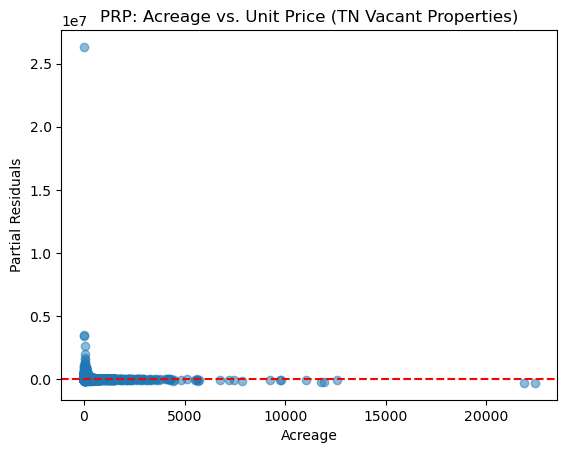

In [15]:
# Redefining X based on the specified columns
X = df_sub2[['CAMACALCAC', 'acreage_squared'] + 
           [col for col in df_sub2.columns if col.startswith(('year_', 'county_', 'topo_', 'road_'))]]
X = sm.add_constant(X)

# 1. Calculate predicted values for the entire dataset
df_sub2['predicted'] = model.predict(X)

# 2. Calculate the effect of CAMACALCAC by removing it from the model and predicting again
X_without_CAMACALCAC = X.copy()
X_without_CAMACALCAC['CAMACALCAC'] = 0  # Setting CAMACALCAC to mean or zero to remove its effect
df_sub2['predicted_without_CAMACALCAC'] = model.predict(X_without_CAMACALCAC)

# Calculate partial residuals
df_sub2['partial_residuals'] = df_sub2['Acreage_Price'] - df_sub2['predicted_without_CAMACALCAC']

# 3. Plot
plt.scatter(df_sub2['CAMACALCAC'], df_sub2['partial_residuals'], alpha=0.5)
plt.axhline(0, color='red', linestyle='--')  # Add a reference line at y=0
plt.xlabel('Acreage')
plt.ylabel('Partial Residuals')
plt.title('PRP: Acreage vs. Unit Price (TN Vacant Properties)')
plt.show()

### Scatter with no controls, for reference:

## Modifications:

In [16]:
# consider root of multicolinearity

# year as a continuous variable (base = 1952 = 1)

# change OLS to FGLS (or maybe WGLS)

# change model formula

In [17]:
# add Time to df_sub2 based on V_SALEYEAR: 1952=1 to 2022=71
df_sub2['Time'] = df_sub2['V_SALEYEAR'] - 1951

In [18]:
# Calculate number of rows before filtering
rows_before = df_sub2.shape[0]

# Filter the dataframe
df_sub2 = df_sub2[df_sub2['Time'] >= 1]

# Calculate number of rows after filtering
rows_after = df_sub2.shape[0]

# Report the number of rows dropped
print(f"Number of rows dropped: {rows_before - rows_after}")

Number of rows dropped: 71


In [19]:
# rename column for clarity:
df_sub2 = df_sub2.rename(columns={'CAMACALCAC': 'Acreage', 'acreage_squared': 'Acreage_sq', 'Acreage_Price': 'Price'})

# add Time_sq
df_sub2['Time_sq'] = df_sub2['Time']**2

In [20]:
# Count of rows where Acreage is less than 1
acreage_lt_1_count = len(df_sub2[df_sub2['Acreage'] < 1])

# Total count of rows in the dataframe
total_count = len(df_sub2)

# Calculate the percentage
percentage_acreage_lt_1 = (acreage_lt_1_count / total_count) * 100

print(f"{percentage_acreage_lt_1:.2f}% of the entries have Acreage < 1.")

0.16% of the entries have Acreage < 1.


In [21]:
original_size = len(df_sub2)
df_sub2 = df_sub2[df_sub2['Acreage'] >= 1]
print(f"Dropped {original_size - len(df_sub2)} rows where Acreage < 1.")

Dropped 82 rows where Acreage < 1.


## Price = β0 + β1A + β2A^2 + β3T + β4T^2 + β5AT + β6A^2T + β7AT^2 + β4A^2T^2 +
## [County, Topo, Road]

In [22]:
# Add interaction terms to df_sub2
df_sub2['A_T'] = df_sub2['Acreage'] * df_sub2['Time']
df_sub2['A_sq_T'] = df_sub2['Acreage_sq'] * df_sub2['Time']
df_sub2['A_T_sq'] = df_sub2['Acreage'] * df_sub2['Time_sq']
df_sub2['A_sq_T_sq'] = df_sub2['Acreage_sq'] * df_sub2['Time_sq']

In [23]:
predictors = ['Acreage', 'Acreage_sq', 'Time', 'Time_sq', 'A_T', 'A_sq_T', 'A_T_sq', 'A_sq_T_sq']
predictors += county_columns + topo_columns + road_columns

In [24]:
# OLS before other approaches:

y = df_sub2['Price']
X = df_sub2[predictors]
X = sm.add_constant(X)

# Convert boolean columns to integers
bool_cols = X.select_dtypes(include='bool').columns
X[bool_cols] = X[bool_cols].astype(int)

# Now try the regression again
model = sm.OLS(y, X).fit()
print(model.summary())

residuals = model.resid
model = sm.OLS(y, X).fit()
residuals = model.resid

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     3.026
Date:                Tue, 19 Dec 2023   Prob (F-statistic):           2.42e-23
Time:                        14:01:05   Log-Likelihood:            -6.6986e+05
No. Observations:               50997   AIC:                         1.340e+06
Df Residuals:                   50890   BIC:                         1.341e+06
Df Model:                         106                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -1.479e+04    1.5

In [25]:
# Estimate the error variance using residuals squared:

df_sub2['resid_sq'] = residuals**2

In [26]:
# Regress the squared residuals on Acreage to get predicted variances:

model_resid = sm.OLS(df_sub2['resid_sq'], sm.add_constant(df_sub2['Acreage'])).fit()
predicted_var = model_resid.predict(sm.add_constant(df_sub2['Acreage']))

In [27]:
negative_value_columns = []

# Check each column for negative values, handling potential mixed types
for col in df_sub2.columns:
    try:
        if df_sub2[col].min() < 0:
            negative_value_columns.append(col)
    except TypeError:
        # Skip columns that are not numeric
        continue

# Print columns with negative values and their minimum values
for col in negative_value_columns:
    print(f"Column: {col}, Minimum Value: {df_sub2[col].min()}")

Column: PRIC_SFBLD, Minimum Value: -3692.01
Column: APR_SFBLD, Minimum Value: -0.02
Column: predicted, Minimum Value: -64317.46102344079
Column: predicted_without_CAMACALCAC, Minimum Value: -13394.869163986205
Column: partial_residuals, Minimum Value: -291705.3770750516


In [28]:
predicted_var.describe()

count    5.099700e+04
mean     1.502085e+10
std      4.127958e+09
min     -3.416673e+11
25%      1.505646e+10
50%      1.564746e+10
75%      1.592698e+10
max      1.627040e+10
dtype: float64

In [29]:
# # Take the inverse of the square root of the predicted variances to get weights:

# df_sub2['weights'] = 1 / np.sqrt(predicted_var)

In [30]:
# negative_var = df_sub2[predicted_var < 0]
# print(negative_var)

In [31]:
# # Use these weights to fit a WGLS model:

# wls_model = sm.WLS(y, X, weights=df_sub2['weights']).fit()
# print(wls_model.summary())

In [32]:
# I could not correctly specify source of heteroskedasticity for WGLS 

In [33]:
# FGLS approach with model as specified above:

In [34]:
# import statsmodels.api as sm
# import numpy as np

# # Initial OLS Estimation
# y = df_sub2['Price']
# X = df_sub2[predictors]
# X = sm.add_constant(X)

# # Convert boolean columns to integers
# bool_cols = X.select_dtypes(include='bool').columns
# X[bool_cols] = X[bool_cols].astype(int)

# model_ols = sm.OLS(y, X).fit()
# residuals = model_ols.resid

# # Estimate Heteroskedasticity
# # Regressing squared residuals on predictors
# model_hetero = sm.OLS(residuals**2, X).fit()
# predicted_var = model_hetero.predict(X)

# # Transform the Data
# # Compute weights: inverse of the square root of predicted variance
# weights = 1 / np.sqrt(predicted_var)

# # Weighted dependent variable and independent variables
# y_transformed = y * weights
# X_transformed = X.multiply(weights, axis=0)

# # Regress Transformed Data
# model_fgls = sm.OLS(y_transformed, X_transformed).fit()

# print(model_fgls.summary())

In [35]:
negative_counts = sum(predicted_var < 0)
total_counts = len(predicted_var)

ratio = negative_counts / total_counts

print(f"Ratio of negative predicted variances to total: {ratio:.4f}")

Ratio of negative predicted variances to total: 0.0050


In [36]:
# potential pitfalls:  model specification, outliers, need for data transformation

In [37]:
# simple heteroskedasticity approach:

y = df_sub2['Price']
X = df_sub2[predictors]
X = sm.add_constant(X)

# Convert boolean columns to integers
bool_cols = X.select_dtypes(include='bool').columns
X[bool_cols] = X[bool_cols].astype(int)

# OLS with heteroskedasticity-robust standard errors (e.g., using HC3 correction)
model = sm.OLS(y, X).fit(cov_type='HC3')

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     10.61
Date:                Tue, 19 Dec 2023   Prob (F-statistic):          6.05e-163
Time:                        14:01:07   Log-Likelihood:            -6.6986e+05
No. Observations:               50997   AIC:                         1.340e+06
Df Residuals:                   50890   BIC:                         1.341e+06
Df Model:                         106                                         
Covariance Type:                  HC3                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -1.479e+04   8371

C:\Users\benja\anaconda3\lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 106, but rank is 103
  warnings.warn('covariance of constraints does not have full '


In [38]:
# ^ multicolinearity warning (expected)

In [39]:
# new approach, no interaction:

predictors = ['Acreage', 'Acreage_sq']
predictors += county_columns + topo_columns + road_columns + year_columns

y = df_sub2['Price']
X = df_sub2[predictors]
X = sm.add_constant(X)

# Convert boolean columns to integers
bool_cols = X.select_dtypes(include='bool').columns
X[bool_cols] = X[bool_cols].astype(int)

# OLS with heteroskedasticity-robust standard errors (e.g., using HC3 correction)
model = sm.OLS(y, X).fit(cov_type='HC3')

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     19.87
Date:                Tue, 19 Dec 2023   Prob (F-statistic):               0.00
Time:                        14:01:11   Log-Likelihood:            -6.6975e+05
No. Observations:               50997   AIC:                         1.340e+06
Df Residuals:                   50826   BIC:                         1.341e+06
Df Model:                         170                                         
Covariance Type:                  HC3                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1725.1912   1673

C:\Users\benja\anaconda3\lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 198, but rank is 170
  warnings.warn('covariance of constraints does not have full '


In [40]:
df_sub2['Acreage'].describe()

count    50997.000000
mean        79.228939
std        258.434405
min          1.000000
25%         22.500000
50%         40.000000
75%         77.000000
max      22410.000000
Name: Acreage, dtype: float64

In [41]:
# Ag, Farm, (no open, forest), tabled
# real value through tax loss, later

In [42]:
# filter using [PT]:
PT_contains2 = ["Farm", "Agricultural"]

df_sub3 = df_sub2[df_sub2['PT'].str.contains('|'.join(PT_contains2), case=False, na=False)]

df_sub3.shape[0] / df_sub2.shape[0]

0.8571092417201012

In [43]:
# no interaction, farm/ag only, 1952-2022:

year_columns = [col for col in year_columns if int(col.split('_')[1]) >= 1953]

predictors = ['Acreage', 'Acreage_sq']
predictors += county_columns + topo_columns + road_columns + year_columns

y = df_sub3['Price']
X = df_sub3[predictors]
X = sm.add_constant(X)

# Convert boolean columns to integers
bool_cols = X.select_dtypes(include='bool').columns
X[bool_cols] = X[bool_cols].astype(int)

# OLS with heteroskedasticity-robust standard errors (e.g., using HC3 correction)
model = sm.OLS(y, X).fit(cov_type='HC3')

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     6.454
Date:                Tue, 19 Dec 2023   Prob (F-statistic):          1.82e-132
Time:                        14:01:13   Log-Likelihood:            -5.7732e+05
No. Observations:               43710   AIC:                         1.155e+06
Df Residuals:                   43539   BIC:                         1.156e+06
Df Model:                         170                                         
Covariance Type:                  HC3                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -1209.4360   2334

C:\Users\benja\anaconda3\lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 170, but rank is 169
  warnings.warn('covariance of constraints does not have full '


In [44]:
df_sub3['V_SALEYEAR'].describe()

count    43710.000000
mean      2002.911942
std         11.806523
min       1952.000000
25%       1994.000000
50%       2003.000000
75%       2013.000000
max       2022.000000
Name: V_SALEYEAR, dtype: float64

In [45]:
# df2 = pd.DataFrame({'Coefficient': model.params.index, 'Estimate': model.params.values,
#                     'StdErr': model.bse.values, 'tValue': model.tvalues.values, 
#                     'pValue': model.pvalues.values})

# # The path to your existing Excel file
# file_path = "C:\\Users\\benja\\OneDrive - University of Tennessee\\Documents - Copy\\Model_Results.xlsx"

# # Your data (assuming df1 and df2 are already created from previous steps)
# with pd.ExcelWriter(file_path, engine='openpyxl', mode='a') as writer:
# #     df1.to_excel(writer, sheet_name='Land_Use_SUR', index=False)

#     # If you have results from the second model (df2) to add:
#     df2.to_excel(writer, sheet_name='Your_Second_Sheet_Name', index=False)

In [46]:
a = 0.000552536
b = -11.55854252
x = -b/(2*a)
round(x, 0)

10460.0

In [47]:
for columns in df_sub3:
    print(columns)

OID
JUR
TAXYR
ST_NUM
ADDRESS
PT
WATERSEWER
ELEC
GAS
CAMADEEDAC
Acreage
LANDUNITS
SUBDIV
LOT
LNDAPRDATE
BLDGS
NUM_MH
TOPO
ROADTYPE
DISTRICT
LANDUSE
IMPTYPE
IMP
YRBLT
EFFYRBLT
STORIES
EXTWALL
BASEAREA
SFLA
GRADE
BLDGCOND
DEPR
LANDTABLE
LANDVAL
LANDUSEVAL
OBYVAL
IMPVAL
APPRAISAL
SALEDATE
SALEYEAR
PRICE
RATIO
DEEDBKPG
SALELABEL
V_SALEDATE
V_SALEYEAR
V_PRICE
V_SALELABL
LANDRATIO
LANDBLDG
LANDIMP
PRICE_SQFT
APR_SQFT
PRIC_SFBLD
APR_SFBLD
APRLNDUNIT
APRLNDUNPR
LNDMKTUNPR
OVRRATE
UNITS
FRONTEFF
FLOODFACTR
LOCFACTOR
TOPOFACTOR
SIZEFACTOR
DEPTHFACTR
MKTCOND
USECOND
V_APRLNU
V_PRICELNU
V_UNITVAL
STATE
ZIP
UPDATED
COUNTY
Price
Acreage_sq
county_BEDFORD
county_BENTON
county_BLEDSOE
county_BLOUNT
county_BRADLEY
county_CAMPBELL
county_CANNON
county_CARROLL
county_CARTER
county_CHEATHAM
county_CLAIBORNE
county_CLAY
county_COCKE
county_COFFEE
county_CROCKETT
county_CUMBERLAND
county_DECATUR
county_DEKALB
county_DICKSON
county_DYER
county_FAYETTE
county_FENTRESS
county_FRANKLIN
county_GIBSON
county_GILES

In [48]:
# cutoff year investigation
# for df_sub3['V_SALEYEAR'].value_counts()

In [49]:
np.percentile(df_sub3['V_SALEYEAR'], 68)

2010.0

In [50]:
# new base years
# 1987, post-Farm Crisis (35 years of data)
# 2002, post-recession (20 years of data)
# 2010, post-recession (12 years of data)

In [51]:
# Create a new DataFrame for the base year 1987
df_1987 = df_sub3[df_sub3['V_SALEYEAR'] > 1987].copy()

# Drop year columns before 1988
year_columns_to_drop_1987 = [col for col in df_1987.columns if col.startswith("year_") and int(col.split('_')[1]) <= 1987]
df_1987.drop(columns=year_columns_to_drop_1987, inplace=True)

# Define predictors for 1987
predictors_1987 = ['Acreage', 'Acreage_sq'] + county_columns + topo_columns + road_columns
predictors_1987 += [col for col in df_1987.columns if col.startswith("year_")]

# Prepare the dataset for 1987
X_1987 = df_1987[predictors_1987]
X_1987 = sm.add_constant(X_1987)

# Convert boolean columns to integers
bool_cols_present_1987 = [col for col in bool_cols if col in X_1987.columns]
X_1987[bool_cols_present_1987] = X_1987[bool_cols_present_1987].astype(int)

# Run OLS for 1987
model_1987 = sm.OLS(df_1987['Price'], X_1987).fit(cov_type='HC3')
print(model_1987.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     19.00
Date:                Tue, 19 Dec 2023   Prob (F-statistic):               0.00
Time:                        14:01:15   Log-Likelihood:            -5.3416e+05
No. Observations:               40320   AIC:                         1.069e+06
Df Residuals:                   40185   BIC:                         1.070e+06
Df Model:                         134                                         
Covariance Type:                  HC3                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               4984.5998   2433

C:\Users\benja\anaconda3\lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 135, but rank is 134
  warnings.warn('covariance of constraints does not have full '


In [52]:
# Create a new DataFrame for the base year 2002
df_2002 = df_sub3[df_sub3['V_SALEYEAR'] > 2002].copy()

# Drop year columns before 2003
year_columns_to_drop_2002 = [col for col in df_2002.columns if col.startswith("year_") and int(col.split('_')[1]) <= 2002]
df_2002.drop(columns=year_columns_to_drop_2002, inplace=True)

# Define predictors for 2002
predictors_2002 = ['Acreage', 'Acreage_sq'] + county_columns + topo_columns + road_columns
predictors_2002 += [col for col in df_2002.columns if col.startswith("year_")]

# Prepare the dataset for 2002
X_2002 = df_2002[predictors_2002]
X_2002 = sm.add_constant(X_2002)

# Convert boolean columns to integers
bool_cols_present_2002 = [col for col in bool_cols if col in X_2002.columns]
X_2002[bool_cols_present_2002] = X_2002[bool_cols_present_2002].astype(int)

# Run OLS for 2002
model_2002 = sm.OLS(df_2002['Price'], X_2002).fit(cov_type='HC3')
print(model_2002.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     13.56
Date:                Tue, 19 Dec 2023   Prob (F-statistic):          1.05e-249
Time:                        14:01:16   Log-Likelihood:            -2.9757e+05
No. Observations:               21964   AIC:                         5.954e+05
Df Residuals:                   21844   BIC:                         5.963e+05
Df Model:                         119                                         
Covariance Type:                  HC3                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               9142.0822   3909

C:\Users\benja\anaconda3\lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 120, but rank is 119
  warnings.warn('covariance of constraints does not have full '


In [53]:
# Create a new DataFrame for the base year 2010
df_2010 = df_sub3[df_sub3['V_SALEYEAR'] > 2010].copy()

# Drop year columns before 2011
year_columns_to_drop_2010 = [col for col in df_2010.columns if col.startswith("year_") and int(col.split('_')[1]) <= 2010]
df_2010.drop(columns=year_columns_to_drop_2010, inplace=True)

# Define predictors for 2010
predictors_2010 = ['Acreage', 'Acreage_sq'] + county_columns + topo_columns + road_columns
predictors_2010 += [col for col in df_2010.columns if col.startswith("year_")]

# Prepare the dataset for 2010
X_2010 = df_2010[predictors_2010]
X_2010 = sm.add_constant(X_2010)

# Convert boolean columns to integers
bool_cols_present_2010 = [col for col in bool_cols if col in X_2010.columns]
X_2010[bool_cols_present_2010] = X_2010[bool_cols_present_2010].astype(int)

# Run OLS for 2010
model_2010 = sm.OLS(df_2010['Price'], X_2010).fit(cov_type='HC3')
print(model_2010.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     27.53
Date:                Tue, 19 Dec 2023   Prob (F-statistic):               0.00
Time:                        14:01:16   Log-Likelihood:            -1.5370e+05
No. Observations:               13179   AIC:                         3.076e+05
Df Residuals:                   13067   BIC:                         3.085e+05
Df Model:                         111                                         
Covariance Type:                  HC3                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               4108.7291   1215

C:\Users\benja\anaconda3\lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 112, but rank is 111
  warnings.warn('covariance of constraints does not have full '


In [54]:
def calculate_turning_point(a, b):
    return -b / (2 * a)

# For the 1952 model
coefficients_1952 = model.params
r_squared_1952 = model.rsquared
a_1952 = coefficients_1952['Acreage_sq']
b_1952 = coefficients_1952['Acreage']

# For the 1987 model
coefficients_1987 = model_1987.params
r_squared_1987 = model_1987.rsquared
a_1987 = coefficients_1987['Acreage_sq']
b_1987 = coefficients_1987['Acreage']

# For the 2002 model
coefficients_2002 = model_2002.params
r_squared_2002 = model_2002.rsquared
a_2002 = coefficients_2002['Acreage_sq']
b_2002 = coefficients_2002['Acreage']

# For the 2010 model
coefficients_2010 = model_2010.params
r_squared_2010 = model_2010.rsquared
a_2010 = coefficients_2010['Acreage_sq']
b_2010 = coefficients_2010['Acreage']

# Calculate the turning points
turning_point_1952 = round(calculate_turning_point(a_1952, b_1952), 2)
turning_point_1987 = round(calculate_turning_point(a_1987, b_1987), 2)
turning_point_2002 = round(calculate_turning_point(a_2002, b_2002), 2)
turning_point_2010 = round(calculate_turning_point(a_2010, b_2010), 2)

# Print the turning points and adjusted R-squared values
print(f"1952 Model: Turning Point = {turning_point_1952} acres; R-squared = {round(r_squared_1952, 4)}")
print(f"1987 Model: Turning Point = {turning_point_1987} acres; R-squared = {round(r_squared_1987, 4)}")
print(f"2002 Model: Turning Point = {turning_point_2002} acres; R-squared = {round(r_squared_2002, 4)}")
print(f"2010 Model: Turning Point = {turning_point_2010} acres; R-squared = {round(r_squared_2010, 4)}")
print("Rationale: 1952 is base of continuous data, 1987 is post-Farm Crisis, 2002 is post-recessionary, 2010 is post-recessionary")

1952 Model: Turning Point = 10459.54 acres; R-squared = 0.0126
1987 Model: Turning Point = 10706.92 acres; R-squared = 0.0129
2002 Model: Turning Point = 11002.25 acres; R-squared = 0.0159
2010 Model: Turning Point = 2512.9 acres; R-squared = 0.0455
Rationale: 1952 is base of continuous data, 1987 is post-Farm Crisis, 2002 is post-recessionary, 2010 is post-recessionary


In [55]:
# df_2010.to_csv('acreage_price_2010base.csv')

In [56]:
# definitely drop if price per acre is <100 or >100,000

In [57]:
for columns in df_2010:
    print(columns)

OID
JUR
TAXYR
ST_NUM
ADDRESS
PT
WATERSEWER
ELEC
GAS
CAMADEEDAC
Acreage
LANDUNITS
SUBDIV
LOT
LNDAPRDATE
BLDGS
NUM_MH
TOPO
ROADTYPE
DISTRICT
LANDUSE
IMPTYPE
IMP
YRBLT
EFFYRBLT
STORIES
EXTWALL
BASEAREA
SFLA
GRADE
BLDGCOND
DEPR
LANDTABLE
LANDVAL
LANDUSEVAL
OBYVAL
IMPVAL
APPRAISAL
SALEDATE
SALEYEAR
PRICE
RATIO
DEEDBKPG
SALELABEL
V_SALEDATE
V_SALEYEAR
V_PRICE
V_SALELABL
LANDRATIO
LANDBLDG
LANDIMP
PRICE_SQFT
APR_SQFT
PRIC_SFBLD
APR_SFBLD
APRLNDUNIT
APRLNDUNPR
LNDMKTUNPR
OVRRATE
UNITS
FRONTEFF
FLOODFACTR
LOCFACTOR
TOPOFACTOR
SIZEFACTOR
DEPTHFACTR
MKTCOND
USECOND
V_APRLNU
V_PRICELNU
V_UNITVAL
STATE
ZIP
UPDATED
COUNTY
Price
Acreage_sq
county_BEDFORD
county_BENTON
county_BLEDSOE
county_BLOUNT
county_BRADLEY
county_CAMPBELL
county_CANNON
county_CARROLL
county_CARTER
county_CHEATHAM
county_CLAIBORNE
county_CLAY
county_COCKE
county_COFFEE
county_CROCKETT
county_CUMBERLAND
county_DECATUR
county_DEKALB
county_DICKSON
county_DYER
county_FAYETTE
county_FENTRESS
county_FRANKLIN
county_GIBSON
county_GILES

In [60]:
df_2010 = df_2010[(df_2010['Price'] >= 100) & (df_2010['Price'] <= 100000)]

In [62]:
predictors_2010 = ['Acreage', 'Acreage_sq'] + \
                  [col for col in df_2010.columns if col.startswith("county_")] + \
                  [col for col in df_2010.columns if col.startswith("topo_")] + \
                  [col for col in df_2010.columns if col.startswith("road_")] + \
                  [col for col in df_2010.columns if col.startswith("year_")]

# Now prepare X_2010 based on the filtered df_2010
X_2010 = df_2010[predictors_2010]
X_2010 = sm.add_constant(X_2010)

# Convert boolean columns to integers
bool_cols = X_2010.select_dtypes(include='bool').columns
X_2010[bool_cols] = X_2010[bool_cols].astype(int)

# Run the OLS model with the filtered data
model_2010 = sm.OLS(df_2010['Price'], X_2010).fit(cov_type='HC3')

# Print the model summary
print(model_2010.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     56.66
Date:                Tue, 19 Dec 2023   Prob (F-statistic):               0.00
Time:                        16:04:17   Log-Likelihood:            -1.2726e+05
No. Observations:               12159   AIC:                         2.547e+05
Df Residuals:                   12047   BIC:                         2.556e+05
Df Model:                         111                                         
Covariance Type:                  HC3                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               4149.0871    849

C:\Users\benja\anaconda3\lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 112, but rank is 111
  warnings.warn('covariance of constraints does not have full '


In [65]:
# Recompute the turning point and R-squared for the edited 2010 model

# Extract the coefficients and adjusted R-squared value from the new model
coefficients_2010_edited = model_2010.params
r_squared_2010_edited = model_2010.rsquared_adj
a_2010_edited = coefficients_2010_edited['Acreage_sq']
b_2010_edited = coefficients_2010_edited['Acreage']

# Calculate the turning point for the edited 2010 model
turning_point_2010_edited = calculate_turning_point(a_2010_edited, b_2010_edited)

# Print the turning point and adjusted R-squared value
print(f"Edited 2010 Model: Turning Point = {round(turning_point_2010_edited, 2)} acres; Adjusted R-squared = {round(r_squared_2010_edited, 4)}")

Edited 2010 Model: Turning Point = 2490.42 acres; Adjusted R-squared = 0.0836
